# Reinforcement Learning with Python: Monte Carlo

This notebook shows how to use Monte Carlo agent to solve [CartPole](https://gym.openai.com/envs/CartPole-v0/) problem

![CartPole](../assets/CartPole-v0.gif)

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import tensorflow as tf
import gym

import matplotlib.pyplot as plt
%matplotlib inline

from pyreinforce.brain import Brain
from pyreinforce.acting import DecayingEpsGreedyPolicy
from pyreinforce.memory import Memory
from pyreinforce import MonteCarloAgent

In [2]:
seed = 123

## Random action

Let's see how much reward we can get by acting randomly on each time step

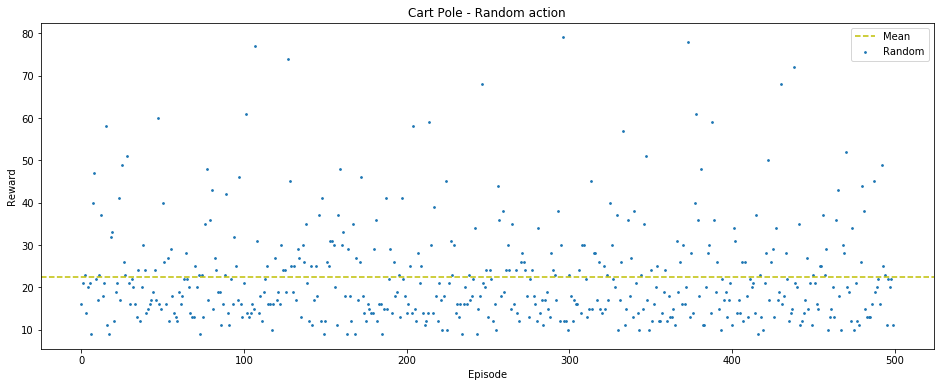

In [3]:
env = gym.make('CartPole-v0')
env.seed(seed)
env.action_space.seed(seed)

n_episodes = 500
rewards = []

for i in range(n_episodes):
    reward = 0
    done = False
    s = env.reset()

    while not done:
        # we always act randomly
        a = env.action_space.sample()

        s1, r, done, _ = env.step(a)
        reward += r

        s = s1

    rewards.append(reward)

plt.figure(figsize=(16, 6))
plt.title('Cart Pole - Random action')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3, label='Random')
plt.axhline(y=np.mean(rewards), c='y', ls='--', label='Mean')
plt.legend()

## Simple action

Can we do better if we always push cart to the left if [pole angle](https://github.com/openai/gym/wiki/CartPole-v0#environment) is negative and to the right otherwise?

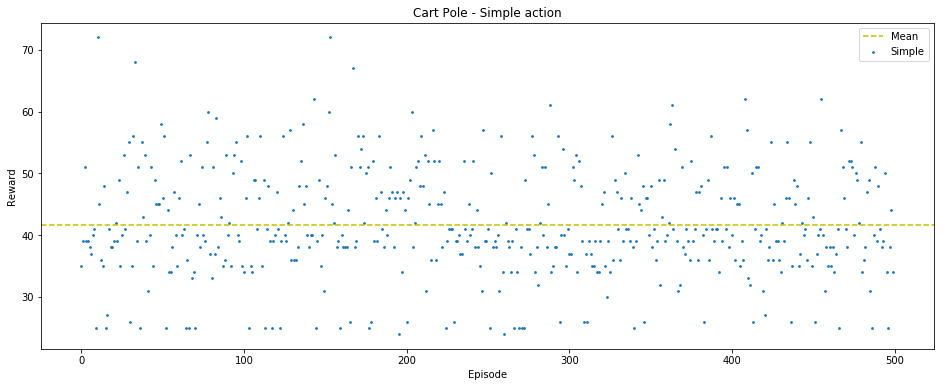

In [4]:
env = gym.make('CartPole-v0')
env.seed(seed)

n_episodes = 500
rewards = []

for i in range(n_episodes):
    reward = 0
    done = False
    s = env.reset()

    while not done:
        # push cart to the left if pole angle is negative 
        # and to the right otherwise
        a = 0 if s[2] < 0 else 1

        s1, r, done, _ = env.step(a)
        reward += r

        s = s1

    rewards.append(reward)

plt.figure(figsize=(16, 6))
plt.title('Cart Pole - Simple action')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3, label='Simple')
plt.axhline(y=np.mean(rewards), color='y', ls='--', label='Mean')
plt.legend()

## Monte Carlo

Now let's configure and train Monte Carlo agent and see how it performs.

First, define Q network by extending `Brain` class that will predict Q values given states, and perform training step using sample returns. We will be using [TensorFlow](https://www.tensorflow.org/) in this example.

In [5]:
class MonteCarloBrain(Brain):
    def __init__(self, n_inputs, n_hidden, n_outputs, lr, seed=None):
        super().__init__()

        tf.reset_default_graph()

        # Input layer
        self._X = tf.placeholder(tf.float32, (None, n_inputs))

        # Hidden layer
        W1 = tf.get_variable('W1', shape=(n_inputs, n_hidden), 
                             initializer=tf.glorot_uniform_initializer(seed))
        b1 = tf.get_variable('b1', shape=(n_hidden,), 
                             initializer=tf.zeros_initializer())
        h1 = tf.nn.relu(tf.matmul(self._X, W1) + b1)

        # Output layer
        W2 = tf.get_variable('W2', shape=(n_hidden, n_outputs), 
                             initializer=tf.glorot_uniform_initializer(seed))
        b2 = tf.get_variable('b2', shape=(n_outputs,), 
                             initializer=tf.zeros_initializer())
        self._Q = tf.matmul(h1, W2) + b2

        # Backpropagation
        self._A = tf.placeholder(tf.uint8, (None,))
        A_one_hot = tf.one_hot(self._A, n_outputs)
        Q = tf.reduce_sum(tf.multiply(self._Q, A_one_hot), axis=1)
        self._G = tf.placeholder(tf.float32, (None,))
        loss = tf.reduce_mean(tf.squared_difference(self._G, Q))
        optimizer = tf.train.GradientDescentOptimizer(lr)
        self._train_op = optimizer.minimize(loss)

        self._sess = tf.Session()

    def predict_q(self, states, **kwargs):
        if len(states.shape) < len(self._X.shape):
            states = np.expand_dims(states, axis=0)

        return self._sess.run(self._Q, {self._X: states})

    def train(self, states, actions, returns, **kwargs):
        self._sess.run(self._train_op, {self._X: states, self._A: actions, self._G: returns})

    def __enter__(self):
        self._sess.__enter__()

        init = tf.global_variables_initializer()
        self._sess.run(init)

        return self

    def __exit__(self, *args):
        self._sess.__exit__(*args)

Then, set all training parameters

In [6]:
# Brain
n_inputs = 4
n_hidden = 32
n_outputs = 2
lr = 0.0005

# Action Selection Policy
start_eps = 1
end_eps = 0
eps_decay = 1

# Replay Memory
replay_memory_size = 100000
replay_batch_size = 32

# Agent
n_episodes = 250
gamma = 0.99

Finally, put it all together by instantiating environment, brain, action selection policy, replay memory and agent, and start training by invoking `run()` method

In [7]:
env = gym.make('CartPole-v0')
env.seed(seed)

brain = MonteCarloBrain(n_inputs, n_hidden, n_outputs, lr, seed)
acting = DecayingEpsGreedyPolicy(start_eps, end_eps, eps_decay)
replay_memory = Memory(replay_memory_size, replay_batch_size)
agent = MonteCarloAgent(n_episodes, env, brain, acting, replay_memory, gamma)
agent.seed(seed)

with brain:
    rewards, _ = agent.run()

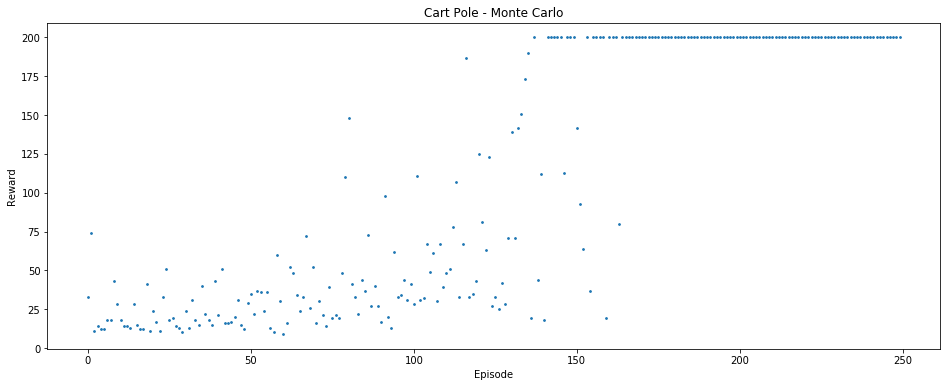

In [8]:
plt.figure(figsize=(16, 6))
plt.title('Cart Pole - Monte Carlo')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3)

### Keras

Alternatively, any other neural network library can be used to build the brain. Here is one created using [Keras](https://www.tensorflow.org/guide/keras)

In [9]:
class KerasMonteCarloBrain(Brain):
    def __init__(self, n_inputs, n_hidden, n_outputs, lr, seed=None):
        super().__init__()

        initializer = tf.glorot_uniform_initializer(seed)

        X = tf.keras.Input(shape=(n_inputs,), dtype=tf.float32)
        h1 = tf.keras.layers.Dense(n_hidden, 'relu', kernel_initializer=initializer)(X)
        Q = tf.keras.layers.Dense(n_outputs, kernel_initializer=initializer)(h1)

        self._Q = tf.keras.Model(inputs=X, outputs=Q)

        A = tf.keras.Input(shape=(), dtype=tf.uint8)
        A_one_hot = tf.one_hot(A, n_outputs)
        Q_action = tf.reduce_sum(tf.multiply(Q, A_one_hot), axis=1, keepdims=True)

        optimizer = tf.keras.optimizers.Adam(lr)
        loss = tf.keras.losses.MeanSquaredError()

        self._model = tf.keras.Model(inputs=[X, A], outputs=Q_action)
        self._model.compile(optimizer=optimizer, loss=loss)

    def predict_q(self, states, **kwargs):
        if states.ndim < 2:
            states = np.expand_dims(states, axis=0)

        return self._Q.predict(states)

    def train(self, states, actions, returns, **kwargs):
        self._model.fit([states, actions], returns, epochs=1, verbose=0)

We will reuse the hyperparameters defined above

In [10]:
env = gym.make('CartPole-v0')
env.seed(seed)

keras_brain = KerasMonteCarloBrain(n_inputs, n_hidden, n_outputs, lr, seed)
acting = DecayingEpsGreedyPolicy(start_eps, end_eps, eps_decay)
replay_memory = Memory(replay_memory_size, replay_batch_size)
agent = MonteCarloAgent(n_episodes, env, keras_brain, acting, replay_memory, gamma)
agent.seed(seed)

rewards, _ = agent.run()

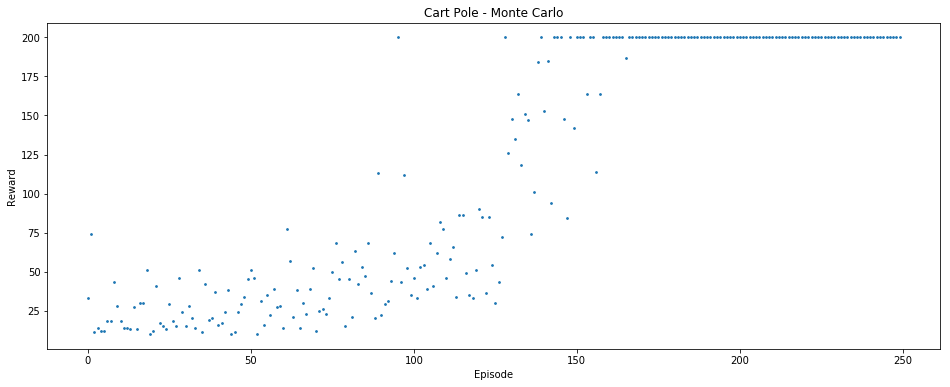

In [11]:
plt.figure(figsize=(16, 6))
plt.title('Cart Pole - Monte Carlo')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3)